In [285]:
import pickle
import multirecording_spikeanalysis as spike
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score



In [263]:
def pickle_this(thing_to_pickle, file_name):
    with open(file_name,'wb') as file:
        pickle.dump(thing_to_pickle, file)

def unpickle_this(pickle_file):
    with open(pickle_file, 'rb') as file:
        return pickle.load(file)

# Ephys Recording Object: Phase 2 (Freely moving)

Each recording is an ephysrecording instance; the documentation is as follows: 

A class for an ephys recording after being spike sorted and manually
curated using phy. Ephys recording must have a phy folder.


    Attributes:
        path: str, relative path to the phy folder
            formatted as: './folder/folder/phy'
        subject: str, subject id who was being recorded
        event_dict: dict, start and stop times for events
            keys: str, name of event types
            values: np.array, d =(n,2), each 2D array is the start and stop time 
            in ms for each event, n = number of events of type key
        sampling_rate: int, sampling rate of the ephys device
            in Hz, standard in the PC lab is 20,000Hz
        timestamps_var: numpy array, all spike timestamps
            of good and mua units (no noise unit-generated spikes)
        unit_array: numpy array, unit ids associated with each
            spike in the timestamps_var
        labels_dict: dict, keys are unit ids (str) and
            values are labels (str)
        unit_timestamps: dict, keys are unit ids (int), and
            values are numpy arrays of timestamps for all spikes
            from "good" units only
        spiketrain: np.array, spiketrain of number of spikes
            in a specified timebin
        unit_spiketrains: dict, spiketrains for each unit
            keys: str, unit ids
            values: np.array, number of spikes per specified timebin
        unit_firing_rates: dict, firing rates per unit
            keys: str, unit ids
            values: np.arrays, firing rate of unit in a specified timebin
                    calculated with a specified smoothing window

    Methods: (all called in __init__)
        get_unit_labels: creates labels_dict
        get_spike_specs: creates timestamps_var and unit_array
        get_unit_timestamps: creates unit_timestamps dictionary


All recordings have been put into an instance of the class type ephysrecordingcollection.
Big picture is that phase2_collection has an attribute called collection which is a dictionary of 
recording names: recording objects. 

In [264]:
phase2_collection = unpickle_this('phase2_collection.pkl')
print(type('phase2_collection.pkl'))
print(type(phase2_collection))

<class 'str'>
<class 'multirecording_spikeanalysis.EphysRecordingCollection'>


In [265]:
is_first = True
for recording_name, recording in phase2_collection.collection.items():
    if is_first:
        print('Example recording:')
        print(recording_name)
        print("")
        print('Event Types:')
        print(recording.event_dict.keys())
        print("")
        print('Number of units:')
        print(len(recording.unit_timestamps.keys()))
        is_first = False

for recording_name, recording in phase2_collection.collection.items():
    print('Example recording:')
    print(recording_name)
    print("")
    print('Number of units:')
    print(len(recording.unit_timestamps.keys()))
     

Example recording:
20230803_101331_1_merged.rec

Event Types:
dict_keys(['acquisition', 'recall', 'cagemate', 'novel', 'exposure 1', 'exposure 2', 'exposure 3'])

Number of units:
52
Example recording:
20230803_101331_1_merged.rec

Number of units:
52
Example recording:
20230803_121318_1_merged.rec

Number of units:
57
Example recording:
20230803_141047_1_merged.rec

Number of units:
62
Example recording:
20230804_121600_1_merged.rec

Number of units:
74
Example recording:
20230804_141009_1_merged.rec

Number of units:
62
Example recording:
20230817_100823_1_merged.rec

Number of units:
53
Example recording:
20230817_113746_1_merged.rec

Number of units:
61
Example recording:
20230818_115728_1_merged.rec

Number of units:
46
Example recording:
20230818_133620_1_merged.rec

Number of units:
76


# Spike Analysis Object

Here is another class I made for spike analysis specifically. 

Parameters that you should feel free to play with are smoothin_window and timebin (both in ms).

    Timebin:
        window for each element in all the arrays (spiketrains, firing rates, etc.).
    Smoothing window:
        the rolling average window size to be used when calculating firing rates. 

**Timebin: This parameter defines the size of the window for each element in the arrays, such as spike trains or firing rates. It determines the resolution at which you analyze your data. A smaller timebin leads to finer resolution but may increase computational complexity.**

**Smoothing window: This parameter sets the size of the rolling average window used for smoothing when calculating firing rates. Smoothing helps reduce noise in the data and provides a clearer representation of underlying patterns. A larger smoothing window results in smoother firing rate curves but may reduce the ability to capture rapid changes in activity.**

In [266]:
# Create an instance of SpikeAnalysis_MultiRecording class
# Parameters:
#   phase2_collection: SpikeDataCollection object containing spike data
#   smoothing_window: Rolling average window size for smoothing firing rates (default: 250)
#   timebin: Window size for each element in spike trains and firing rate arrays (default: 50)
#   ignore_freq: Frequency below which units are ignored (default: 0.5)

phase2_analysis = spike.SpikeAnalysis_MultiRecording(
    phase2_collection,
    smoothing_window = 250,
    timebin = 50,
    ignore_freq = 0.5)

for recording_name, recording in phase2_collection.collection.items():
    print('Example recording:')
    print(recording_name)
    print("")
    print('Number of units:')
    print(len(recording.unit_spiketrains.keys()))


All set to analyze
Example recording:
20230803_101331_1_merged.rec

Number of units:
18
Example recording:
20230803_121318_1_merged.rec

Number of units:
19
Example recording:
20230803_141047_1_merged.rec

Number of units:
32
Example recording:
20230804_121600_1_merged.rec

Number of units:
28
Example recording:
20230804_141009_1_merged.rec

Number of units:
28
Example recording:
20230817_100823_1_merged.rec

Number of units:
21
Example recording:
20230817_113746_1_merged.rec

Number of units:
22
Example recording:
20230818_115728_1_merged.rec

Number of units:
17
Example recording:
20230818_133620_1_merged.rec

Number of units:
30


In [267]:
print(recording.event_dict)

{'acquisition': array([[ 27800.,  39500.],
       [ 41600.,  47367.],
       [ 59733.,  61033.],
       [ 96267.,  97667.],
       [126867., 129100.],
       [135500., 136200.],
       [237333., 238067.],
       [361367., 362400.],
       [367467., 370033.],
       [439400., 440300.],
       [443767., 444300.],
       [577867., 578667.],
       [595433., 598433.]]), 'recall': array([[1510367., 1517767.],
       [1520133., 1521400.],
       [1531400., 1538900.],
       [1542833., 1546467.],
       [1549000., 1549767.],
       [1577700., 1579100.],
       [1599200., 1599867.],
       [1676033., 1676967.],
       [1679467., 1682767.],
       [1766133., 1766900.]]), 'cagemate': array([[1202233., 1203467.],
       [1207200., 1217200.],
       [1223233., 1226167.],
       [1244033., 1245700.],
       [1282467., 1283000.],
       [1303200., 1303700.],
       [1330333., 1331167.],
       [1334633., 1337600.],
       [1348800., 1349800.],
       [1438367., 1438867.],
       [1442600., 1444833.]

**20230804_121600_1_merged.rec**

In [268]:
event_firing_rates = {}
#event type
event = 'recall'
#event length (in seconds)
equalize = 3
#time prior to event start to be included (in seconds)
pre_window = 2


#will calculate unit firing rates during specified event type for specified length of time
#and save them into a dictionary 
for recording_name, recording in phase2_collection.collection.items(): 
        
    event_firing_rates[recording_name] = phase2_analysis.__get_unit_event_firing_rates__(
            recording,
            event,
            equalize,
            pre_window 
                    )
            # this will create a dictionary
            # recording_name : dictionary (units)
            # unit dictionary: {unit_id: [[.....]...[.....]}
            # unit id = 80 for example
            # len of list = number of sniffs 
            # length of each array equals equalize * 1000 / timebins 
            # i.e. 100 ms timebin + 5 second long sniff
            # convert seconds to ms 5 * 1000 = 5000 ms long sniffs 
            # 5000 ms sniff / 100 ms timebins = length of each array


#give you the list of units for this recording
event_firing_rates['20230804_121600_1_merged.rec'].keys()

#give you a list of the firi(ng rates
recall_firing_rates = np.array(list(event_firing_rates['20230804_121600_1_merged.rec'].values()))
avg_recall_firing_rates = np.mean(recall_firing_rates, axis = 2)
avg_recall_tbyn = avg_recall_firing_rates.transpose()
y_label = ["recall"] * 11



#this is the number of sniffs you have for this session 
#len(event_firing_rates['20230804_121600_1_merged.rec'][80])

#length of sniff you asked for in timebin sized elements
#specifically this is giving the length of the first acquistion sniff
# for this recording for unit 80

#len(event_firing_rates['20230804_121600_1_merged.rec'][80][0])

#zscore_global(self, event, equalize, pre_window = 0, global_timebin = 1000, SD = None, plot = True, save = False)

#global_zscore_acq = phase2_analysis.zscore_global(event, equalize, pre_window, SD = 1)


#zscore_acq = phase2_analysis.zscore_pre_event(event, equalize, pre_window)

#print(zscore_acq)


**20230804_121600_1_merged.rec**

In [269]:
cagemate_firing_rates = {}
#event type
event = 'cagemate'
#event length (in seconds)
equalize = 3
#time prior to event start to be included (in seconds)
pre_window = 2


#will calculate unit firing rates during specified event type for specified length of time
#and save them into a dictionary 
for recording_name, recording in phase2_collection.collection.items():     
    cagemate_firing_rates[recording_name] = phase2_analysis.__get_unit_event_firing_rates__(
            recording,
            event,
            equalize,
            pre_window 
                    )
            # this will create a dictionary
            # recording_name : dictionary (units)
            # unit dictionary: {unit_id: [[.....]...[.....]}
            # unit id = 80 for example
            # len of list = number of sniffs 
            # length of each array equals equalize * 1000 / timebins 
            # i.e. 100 ms timebin + 5 second long sniff
            # convert seconds to ms 5 * 1000 = 5000 ms long sniffs 
            # 5000 ms sniff / 100 ms timebins = length of each array


#give you the list of units for this recording
cagemate_firing_rates['20230804_121600_1_merged.rec'].keys()

#give you a list of the firing rates
cagemate_firing_rates = np.array(list(cagemate_firing_rates['20230804_121600_1_merged.rec'].values()))
avg_cagemate_firing_rates = np.mean(cagemate_firing_rates, axis = 2)
avg_cagemate_tbyn = avg_cagemate_firing_rates.transpose()
cagemate_label = ["cagemate"] * 11


In [270]:
cagemate_v_recall = np.concatenate([avg_cagemate_tbyn, avg_recall_tbyn], axis = 0)
print(cagemate_v_recall.shape)
labels = cagemate_label + y_label
print(labels)
shuffle = np.random.permutation(len(cagemate_v_recall))
print(shuffle)
labels = np.array(labels)
labels_shuffle = labels[shuffle]
cagemate_v_recall_shuffle = cagemate_v_recall[shuffle]
print(labels_shuffle)


accuracies = cross_val_score(LogisticRegression(penalty="l1", solver="liblinear"), cagemate_v_recall_shuffle, labels_shuffle, cv=5)

#accuracies = cross_val_score(LogisticRegression(penalty="l1"), cagemate_v_recall_shuffle, labels_shuffle, cv=5)  # k=8 cross validation

(22, 28)
['cagemate', 'cagemate', 'cagemate', 'cagemate', 'cagemate', 'cagemate', 'cagemate', 'cagemate', 'cagemate', 'cagemate', 'cagemate', 'recall', 'recall', 'recall', 'recall', 'recall', 'recall', 'recall', 'recall', 'recall', 'recall', 'recall']
[12  2 18  9  3  6  0  4 21  1 17 20 10 19  5 15  7 14 13 16  8 11]
['recall' 'cagemate' 'recall' 'cagemate' 'cagemate' 'cagemate' 'cagemate'
 'cagemate' 'recall' 'cagemate' 'recall' 'recall' 'cagemate' 'recall'
 'cagemate' 'recall' 'cagemate' 'recall' 'recall' 'recall' 'cagemate'
 'recall']


Input data shape: (22, 28)
Labels shape: (22,)
Input data type: float64
Labels type: <U8
Missing values in input data: False
Accuracies: [1. 1. 1. 1. 1.]
Mean Accuracy: 1.0


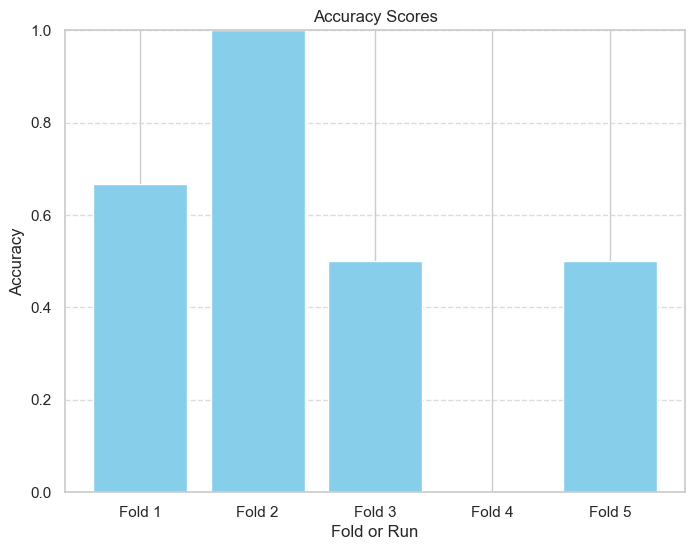

In [271]:
print("Input data shape:", cagemate_v_recall_shuffle.shape)
print("Labels shape:", labels_shuffle.shape)
print("Input data type:", cagemate_v_recall_shuffle.dtype)
print("Labels type:", labels_shuffle.dtype)
print("Missing values in input data:", np.isnan(cagemate_v_recall_shuffle).any())

model = LogisticRegression(penalty="l1", solver="liblinear")

accuracies = cross_val_score(model, cagemate_v_recall_shuffle, labels_shuffle, cv=5)
print("Accuracies:", accuracies)

print("Mean Accuracy:", np.mean(accuracies))

import matplotlib.pyplot as plt

# Accuracy scores
accuracies = [0.66666667, 1.  ,       0.5    ,    0.     ,    0.5 ]

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(range(len(accuracies)), accuracies, color='skyblue')
plt.xlabel('Fold or Run')
plt.ylabel('Accuracy')
plt.title('Accuracy Scores')
plt.ylim(0, 1)  # Set y-axis limit to 0-1 for accuracy
plt.xticks(range(len(accuracies)), [f'Fold {i+1}' for i in range(len(accuracies))])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



**20230803_101331_1_merged.rec**

In [272]:
event_firing_rates = {}
#event type
event = 'recall'
#event length (in seconds)
equalize = 3
#time prior to event start to be included (in seconds)
pre_window = 2


#will calculate unit firing rates during specified event type for specified length of time
#and save them into a dictionary 
for recording_name, recording in phase2_collection.collection.items(): 
        
    event_firing_rates[recording_name] = phase2_analysis.__get_unit_event_firing_rates__(
            recording,
            event,
            equalize,
            pre_window 
                    )
            # this will create a dictionary
            # recording_name : dictionary (units)
            # unit dictionary: {unit_id: [[.....]...[.....]}
            # unit id = 80 for example
            # len of list = number of sniffs 
            # length of each array equals equalize * 1000 / timebins 
            # i.e. 100 ms timebin + 5 second long sniff
            # convert seconds to ms 5 * 1000 = 5000 ms long sniffs 
            # 5000 ms sniff / 100 ms timebins = length of each array


#give you the list of units for this recording
event_firing_rates['20230803_101331_1_merged.rec'].keys()

#give you a list of the firi(ng rates
recall_firing_rates = np.array(list(event_firing_rates['20230803_101331_1_merged.rec'].values()))
avg_recall_firing_rates = np.mean(recall_firing_rates, axis = 2)
avg_recall_tbyn = avg_recall_firing_rates.transpose()
y_label = ["recall"] * 4
print(recall_firing_rates.shape)


(18, 4, 100)


In [273]:
cagemate_firing_rates = {}
#event type
event = 'cagemate'
#event length (in seconds)
equalize = 3
#time prior to event start to be included (in seconds)
pre_window = 2


#will calculate unit firing rates during specified event type for specified length of time
#and save them into a dictionary 
for recording_name, recording in phase2_collection.collection.items():     
    cagemate_firing_rates[recording_name] = phase2_analysis.__get_unit_event_firing_rates__(
            recording,
            event,
            equalize,
            pre_window 
                    )
            # this will create a dictionary
            # recording_name : dictionary (units)
            # unit dictionary: {unit_id: [[.....]...[.....]}
            # unit id = 80 for example
            # len of list = number of sniffs 
            # length of each array equals equalize * 1000 / timebins 
            # i.e. 100 ms timebin + 5 second long sniff
            # convert seconds to ms 5 * 1000 = 5000 ms long sniffs 
            # 5000 ms sniff / 100 ms timebins = length of each array


#give you the list of units for this recording
cagemate_firing_rates['20230803_101331_1_merged.rec'].keys()

#give you a list of the firing rates
cagemate_firing_rates = np.array(list(cagemate_firing_rates['20230803_101331_1_merged.rec'].values()))
avg_cagemate_firing_rates = np.mean(cagemate_firing_rates, axis = 2)
avg_cagemate_tbyn = avg_cagemate_firing_rates.transpose()
cagemate_label = ["cagemate"] * 6
print(cagemate_firing_rates.shape)

(18, 6, 100)


In [274]:
cagemate_v_recall = np.concatenate([avg_cagemate_tbyn, avg_recall_tbyn], axis = 0)
print(cagemate_v_recall.shape)
labels = cagemate_label + y_label
print(labels)
shuffle = np.random.permutation(len(cagemate_v_recall))
print(shuffle)
labels = np.array(labels)
labels_shuffle = labels[shuffle]
cagemate_v_recall_shuffle = cagemate_v_recall[shuffle]
print(labels_shuffle)
print(cagemate_label)

accuracies = cross_val_score(LogisticRegression(penalty="l1", solver="liblinear"), cagemate_v_recall_shuffle, labels_shuffle, cv=3)
print(accuracies)


#accuracies = cross_val_score(LogisticRegression(penalty="l1"), cagemate_v_recall_shuffle, labels_shuffle, cv=5)  # k=8 cross validation

(10, 18)
['cagemate', 'cagemate', 'cagemate', 'cagemate', 'cagemate', 'cagemate', 'recall', 'recall', 'recall', 'recall']
[6 2 9 4 1 0 8 5 7 3]
['recall' 'cagemate' 'recall' 'cagemate' 'cagemate' 'cagemate' 'recall'
 'cagemate' 'recall' 'cagemate']
['cagemate', 'cagemate', 'cagemate', 'cagemate', 'cagemate', 'cagemate']
[0.75       0.66666667 1.        ]


In [259]:
print("Size of labels array:", len(labels))
print("Size of shuffle array:", len(shuffle))
print("Shuffled indices:", shuffle)
print("Length of cagemate_label:", len(cagemate_label))
print("Length of y_label:", len(y_label))
print("Length of cagemate_v_recall:", len(cagemate_v_recall))


Size of labels array: 10
Size of shuffle array: 10
Shuffled indices: [6 0 8 5 4 9 3 7 2 1]
Length of cagemate_label: 6
Length of y_label: 4
Length of cagemate_v_recall: 10


**20230803_121318_1_merged.rec**

In [260]:
event_firing_rates = {}
#event type
event = 'recall'
#event length (in seconds)
equalize = 3
#time prior to event start to be included (in seconds)
pre_window = 2


#will calculate unit firing rates during specified event type for specified length of time
#and save them into a dictionary 
for recording_name, recording in phase2_collection.collection.items(): 
        
    event_firing_rates[recording_name] = phase2_analysis.__get_unit_event_firing_rates__(
            recording,
            event,
            equalize,
            pre_window 
                    )
            # this will create a dictionary
            # recording_name : dictionary (units)
            # unit dictionary: {unit_id: [[.....]...[.....]}
            # unit id = 80 for example
            # len of list = number of sniffs 
            # length of each array equals equalize * 1000 / timebins 
            # i.e. 100 ms timebin + 5 second long sniff
            # convert seconds to ms 5 * 1000 = 5000 ms long sniffs 
            # 5000 ms sniff / 100 ms timebins = length of each array


#give you the list of units for this recording
event_firing_rates['20230803_121318_1_merged.rec'].keys()

#give you a list of the firi(ng rates
recall_firing_rates = np.array(list(event_firing_rates['20230803_121318_1_merged.rec'].values()))
avg_recall_firing_rates = np.mean(recall_firing_rates, axis = 2)
avg_recall_tbyn = avg_recall_firing_rates.transpose()
y_label = ["recall"] * 6
print(recall_firing_rates.shape)


(19, 6, 100)


(21, 32)
['cagemate', 'cagemate', 'cagemate', 'cagemate', 'cagemate', 'cagemate', 'cagemate', 'cagemate', 'cagemate', 'recall', 'recall', 'recall', 'recall', 'recall', 'recall', 'recall', 'recall', 'recall', 'recall', 'recall', 'recall']
[ 8 10  9 19  5 18  3 17 13  6  7 11 12 14  1 20 16 15  4  0  2]
['cagemate' 'recall' 'recall' 'recall' 'cagemate' 'recall' 'cagemate'
 'recall' 'recall' 'cagemate' 'cagemate' 'recall' 'recall' 'recall'
 'cagemate' 'recall' 'recall' 'recall' 'cagemate' 'cagemate' 'cagemate']
[0.83333333 0.8        0.8        0.6       ]


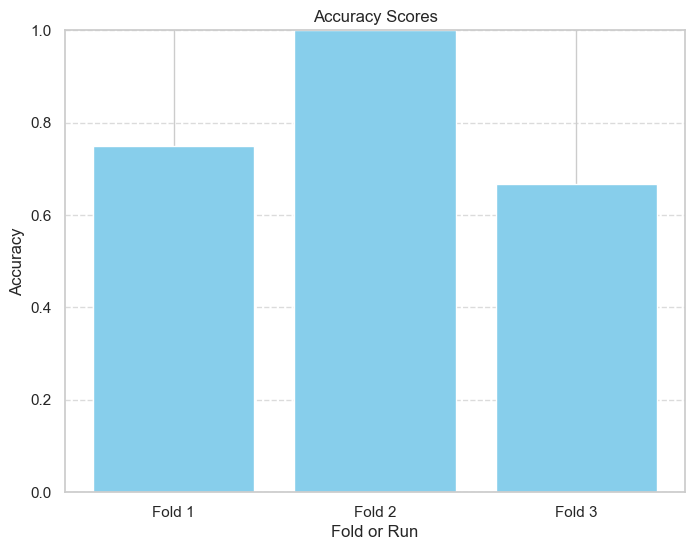

In [284]:
cagemate_v_recall = np.concatenate([avg_cagemate_tbyn, avg_recall_tbyn], axis = 0)
print(cagemate_v_recall.shape)
labels = cagemate_label + y_label
print(labels)
shuffle = np.random.permutation(len(cagemate_v_recall))
print(shuffle)
labels = np.array(labels)
labels_shuffle = labels[shuffle]
cagemate_v_recall_shuffle = cagemate_v_recall[shuffle]
print(labels_shuffle)


accuracies = cross_val_score(LogisticRegression(penalty="l1", solver="liblinear"), cagemate_v_recall_shuffle, labels_shuffle, cv=4)
print(accuracies)


# Accuracy scores
accuracies = [.75, 1. , .66666667 ]

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(range(len(accuracies)), accuracies, color='skyblue')
plt.xlabel('Fold or Run')
plt.ylabel('Accuracy')
plt.title('Accuracy Scores')
plt.ylim(0, 1)  # Set y-axis limit to 0-1 for accuracy
plt.xticks(range(len(accuracies)), [f'Fold {i+1}' for i in range(len(accuracies))])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


#accuracies = cross_val_score(LogisticRegression(penalty="l1"), cagemate_v_recall_shuffle, labels_shuffle, cv=5)  # k=8 cross validation

**20230803_141047_1_merged.rec** recall 

In [282]:
event_firing_rates = {}
#event type
event = 'recall'
#event length (in seconds)
equalize = 3
#time prior to event start to be included (in seconds)
pre_window = 2


#will calculate unit firing rates during specified event type for specified length of time
#and save them into a dictionary 
for recording_name, recording in phase2_collection.collection.items(): 
        
    event_firing_rates[recording_name] = phase2_analysis.__get_unit_event_firing_rates__(
            recording,
            event,
            equalize,
            pre_window 
                    )
            # this will create a dictionary
            # recording_name : dictionary (units)
            # unit dictionary: {unit_id: [[.....]...[.....]}
            # unit id = 80 for example
            # len of list = number of sniffs 
            # length of each array equals equalize * 1000 / timebins 
            # i.e. 100 ms timebin + 5 second long sniff
            # convert seconds to ms 5 * 1000 = 5000 ms long sniffs 
            # 5000 ms sniff / 100 ms timebins = length of each array


#give you the list of units for this recording
event_firing_rates['20230803_141047_1_merged.rec'].keys()

#give you a list of the firi(ng rates
recall_firing_rates = np.array(list(event_firing_rates['20230803_141047_1_merged.rec'].values()))
avg_recall_firing_rates = np.mean(recall_firing_rates, axis = 2)
avg_recall_tbyn = avg_recall_firing_rates.transpose()
y_label = ["recall"] * 12
print(recall_firing_rates.shape)


(32, 12, 100)


**20230803_141047_1_merged.rec** cagemate 

In [280]:
cagemate_firing_rates = {}
#event type
event = 'cagemate'
#event length (in seconds)
equalize = 3
#time prior to event start to be included (in seconds)
pre_window = 2


#will calculate unit firing rates during specified event type for specified length of time
#and save them into a dictionary 
for recording_name, recording in phase2_collection.collection.items():     
    cagemate_firing_rates[recording_name] = phase2_analysis.__get_unit_event_firing_rates__(
            recording,
            event,
            equalize,
            pre_window 
                    )
            # this will create a dictionary
            # recording_name : dictionary (units)
            # unit dictionary: {unit_id: [[.....]...[.....]}
            # unit id = 80 for example
            # len of list = number of sniffs 
            # length of each array equals equalize * 1000 / timebins 
            # i.e. 100 ms timebin + 5 second long sniff
            # convert seconds to ms 5 * 1000 = 5000 ms long sniffs 
            # 5000 ms sniff / 100 ms timebins = length of each array


#give you the list of units for this recording
cagemate_firing_rates['20230803_141047_1_merged.rec'].keys()

#give you a list of the firing rates
cagemate_firing_rates = np.array(list(cagemate_firing_rates['20230803_141047_1_merged.rec'].values()))
avg_cagemate_firing_rates = np.mean(cagemate_firing_rates, axis = 2)
avg_cagemate_tbyn = avg_cagemate_firing_rates.transpose()
cagemate_label = ["cagemate"] * 9
print(cagemate_firing_rates.shape)

(32, 9, 100)


In [286]:
cagemate_v_recall = np.concatenate([avg_cagemate_tbyn, avg_recall_tbyn], axis = 0)
print(cagemate_v_recall.shape)
labels = cagemate_label + y_label
print(labels)
shuffle = np.random.permutation(len(cagemate_v_recall))
print(shuffle)
labels = np.array(labels)
labels_shuffle = labels[shuffle]
cagemate_v_recall_shuffle = cagemate_v_recall[shuffle]
print(labels_shuffle)
print(cagemate_label)

accuracies = cross_val_score(LogisticRegression(penalty="l1", solver="liblinear"), cagemate_v_recall_shuffle, labels_shuffle, cv=5)
print(accuracies)


#accuracies = cross_val_score(LogisticRegression(penalty="l1"), cagemate_v_recall_shuffle, labels_shuffle, cv=5)  # k=8 cross validation

(21, 32)
['cagemate', 'cagemate', 'cagemate', 'cagemate', 'cagemate', 'cagemate', 'cagemate', 'cagemate', 'cagemate', 'recall', 'recall', 'recall', 'recall', 'recall', 'recall', 'recall', 'recall', 'recall', 'recall', 'recall', 'recall']
[17  7 18 13  1 19  9 11 12 15  3  6  0 16  2 10 14  8  5  4 20]
['recall' 'cagemate' 'recall' 'recall' 'cagemate' 'recall' 'recall'
 'recall' 'recall' 'recall' 'cagemate' 'cagemate' 'cagemate' 'recall'
 'cagemate' 'recall' 'recall' 'cagemate' 'cagemate' 'cagemate' 'recall']
['cagemate', 'cagemate', 'cagemate', 'cagemate', 'cagemate', 'cagemate', 'cagemate', 'cagemate', 'cagemate']
[1.   1.   1.   0.75 0.75]


In [287]:
print(cagemate_firing_rates)

[[[ 3.2   3.12  3.12 ...  2.16  2.16  2.16]
  [ 5.28  5.2   5.2  ...  5.92  5.76  5.76]
  [ 5.92  6.    6.   ...  6.16  6.24  6.16]
  ...
  [ 5.76  5.76  5.76 ...  5.68  5.84  5.84]
  [ 5.68  5.76  5.76 ...  5.68  5.68  5.6 ]
  [ 5.76  5.76  5.76 ...  7.28  7.28  7.28]]

 [[ 3.6   3.6   3.6  ...  4.48  4.48  4.48]
  [ 4.8   4.88  4.96 ...  5.12  5.04  4.96]
  [ 4.8   4.8   4.8  ...  4.64  4.64  4.72]
  ...
  [ 5.04  5.04  5.04 ...  4.8   4.8   4.8 ]
  [ 4.16  4.16  4.16 ...  4.24  4.24  4.24]
  [ 3.44  3.44  3.44 ...  3.36  3.36  3.36]]

 [[ 4.16  4.16  4.16 ...  4.72  4.56  4.56]
  [ 2.72  2.72  2.72 ...  2.32  2.32  2.32]
  [ 2.64  2.64  2.64 ...  3.68  3.68  3.68]
  ...
  [ 2.32  2.32  2.4  ...  2.56  2.56  2.56]
  [ 2.24  2.24  2.24 ...  2.16  2.16  2.16]
  [ 2.56  2.56  2.48 ...  2.08  2.08  2.08]]

 ...

 [[ 7.68  7.68  7.68 ... 12.88 12.88 12.8 ]
  [ 9.28  9.28  9.28 ...  8.8   8.88  8.8 ]
  [ 7.6   7.44  7.44 ...  7.28  7.28  7.28]
  ...
  [ 4.24  4.24  4.24 ...  3.2   3.2   3.

**Failed loop. This code iterates over each event type, calculates firing rates for all recall (e.g. short term), combines them with the cagemate (long-term) firing rates, shuffles the data, performs logistic regression with cross-validation, and prints the mean accuracy for each event type. Finally, it prints the overall mean accuracy across all event types.**

**Since the recordings are not the same number of unit this code isnt working tried to pad the data with zeros to make them even in lenght still no luck.**

Now to just do them one at a time...



In [ ]:
event_types = ['recall', 'cagemate']
equalize = 3
pre_window = 2
accuracies_all = []
model_dict = {}
event_firing_rates = []

for event in event_types:
    #event_firing_rates = {}
    
    for recording_name, recording in phase2_collection.collection.items():     
        rates = phase2_analysis.__get_unit_event_firing_rates__(
            recording,
            event,
            equalize,
            pre_window 
        )
        #event_firing_rates[recording_name] = rates
    
    # Pad all sublists to the same maximum length
    
    #for rates in event_firing_rates.values():
    for rate in rates: 
        #values = list(rates.values())
        event_rates.append(rate)
        # for sublist in values:
        #     sublist.extend([0] * (max_sublist_length - len(sublist)))  # Pad each sublist with zeros
        # event_rates.extend(values)

    print(f"Length of sublists for event {event}: {[len(sublist) for sublist in event_rates]}")  # Debugging statement

    event_rates = np.array(event_rates)  # Convert to NumPy array
    print(f"Shape of event_rates for {event}: {event_rates.shape}")
  



TypeError: object of type 'numpy.int32' has no len()

In [ ]:
  
avg_event_rates = np.mean(event_rates, axis=2).transpose()
labels = [event] * avg_event_rates.shape[0]

data_combined = np.concatenate([avg_event_rates, avg_cagemate_tbyn], axis=0)
labels_combined = labels + ["cagemate"] * avg_cagemate_tbyn.shape[0]

shuffle = np.random.permutation(len(data_combined))
data_shuffled = data_combined[shuffle]
labels_shuffled = np.array(labels_combined)[shuffle]

model = LogisticRegression(penalty="l1", solver="liblinear")
accuracies = cross_val_score(model, data_shuffled, labels_shuffled, cv=5)
accuracies_all.append(accuracies)

print(f"Mean Accuracy for {event}: {np.mean(accuracies)}")

print("Overall Mean Accuracy:", np.mean(accuracies_all))

# Find the maximum sublist length across all events
max_sublist_length = max(len(rates) for event_rates in event_firing_rates.values() for rates in event_rates.values())


AxisError: axis 2 is out of bounds for array of dimension 1

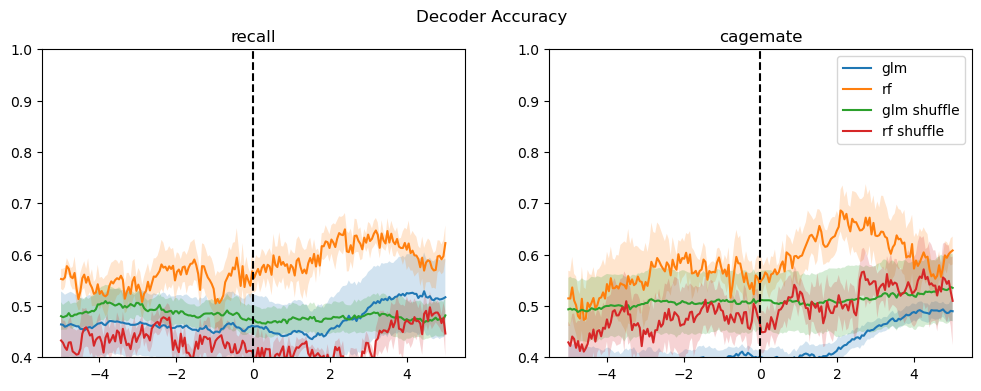

In [ ]:
# Preprocess phase2 dataset for Logistic Regression

#trial_decoder(self, equalize, pre_window, post_window, num_fold, num_shuffle, no_PCs, events, plot = True)
[auc, prob]= phase2_analysis.trial_decoder(equalize=5,
                            pre_window=5,
                            post_window = 0,
                            num_fold = 5, 
                            num_shuffle = 1,
                            no_PCs = 8, 
                            events = ['recall', 'cagemate'],
                            plot = True)

#X_train_phase2, X_test_phase2, y_train_phase2, y_test_phase2 = train_test_split(X_phase2, y_phase2, test_size=0.2)


# Phase 3: Constrained 


In [ ]:
phase3_collection = unpickle_this('phase3_collection.pkl')

In [ ]:
is_first = True
for recording_name, recording in phase3_collection.collection.items():
    if is_first:
        print('Example recording:')
        print(recording_name)
        print("")
        print('Event Types:')
        print(recording.event_dict.keys())
        print("")
        print('Number of units:')
        print(len(recording.unit_timestamps.keys()))
        is_first = False

Example recording:
20230809_103121_1_merged.rec

Event Types:
dict_keys(['acquisition', 'cagemate', 'empty', 'novel', 'familiar'])

Number of units:
36
